In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')


In [116]:
df = pd.read_csv('./data/ghana_gdp.csv',
                 index_col='year', parse_dates=['year'])

display(df.head())
display(df.info())


,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


None

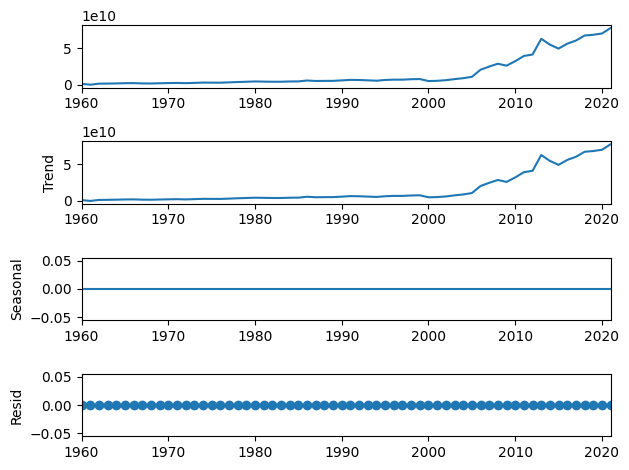

In [117]:
decompose = seasonal_decompose(df)
decompose.plot()
plt.show()


### Наличие восходящего тренда, отсуствие сезонности

---

In [118]:
train_df = df[:-3]
test_df = df[-3:]


---

### Модель скользящего среднего

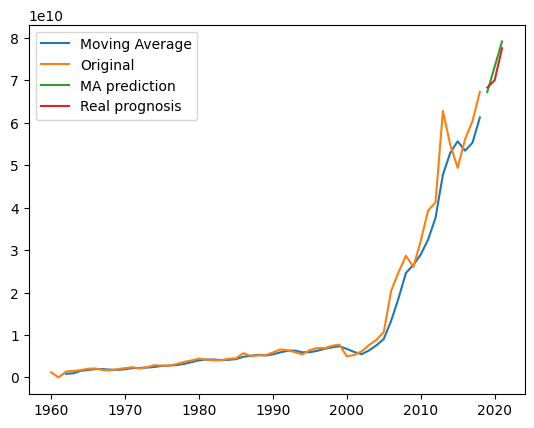

In [119]:
# Moving average prediction
def ma_prediction(train_data, test_data=None, window_size=3, pred_num=3):

    data_ma = train_data.rolling(window_size).mean()
    last_values = data_ma.tail(window_size).values
    prediction = np.array([last_values[-1] +
                           (last_values[-1] - last_values[-2]) * i for i in range(1, pred_num + 1)])
    prediction = pd.DataFrame(
        prediction, columns=test_data.columns, index=test_data.index)
    return data_ma, prediction


ma_model, ma_pred = ma_prediction(train_df, test_df, window_size=3)
plt.plot(ma_model, label='Moving Average')
plt.plot(train_df, label='Original')
plt.plot(ma_pred, label='MA prediction')
plt.plot(test_df, label='Real prognosis')
plt.legend('Прогноз через скользящее среднее')
plt.legend()
plt.show()


#### Вывод: модель скользящего среднего достаточно точно предсказывает значения для тестового периода в случае окна скольжения равного 2-3.

---

### Проверка на стационарность

In [120]:
def stationary(data, p_value=0.05):
    stats = adfuller(data)
    if stats[1] > p_value:
        print('Timeseries is stationary')
    else:
        print('Timeseries is not stationary')

stationary(df)


Timeseries is stationary


#### Вывод: ряд стационарен для дальнейшей работы берем модель ARMA

---